In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

In [2]:
# Load the KDD99 dataset
dataset = pd.read_csv('../dataset/kddcup.data.gz')

In [3]:
# Preprocess the data
def preprocess(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col] = df[col].astype('category').cat.codes
    # df.to_csv("../Preprocess/kddcup.data.csv")
    return df.values

df = preprocess(dataset)

In [4]:
# Split the data into training and test sets
train_data = df[:int(len(df) * 0.9)]
test_data = df[int(len(df) * 0.9):]

In [5]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(np.prod(train_data.shape[1:]), activation='tanh'))
    model.add(tf.keras.layers.Reshape(target_shape=train_data.shape[1:]))
    return model

generator = make_generator_model()

In [6]:
# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=train_data.shape[1:]))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

discriminator = make_discriminator_model()

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Freeze the weights of the discriminator
discriminator.trainable = False

In [7]:
# Define the combined model for training the generator
def make_gan(discriminator, generator):
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

gan = make_gan(discriminator, generator)

# Compile the combined model
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

In [8]:
# Train the GAN
def train(gan, discriminator, generator, train_data, batch_size=128, epochs=100):
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, train_data.shape[0], half_batch)
        real_data = train_data[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_data = generator.predict(noise)
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, fake_labels)

        # Print progress
        print("Epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch + 1, d_loss[0], 100 * d_loss[1], g_loss))

train(gan, discriminator, generator, train_data, epochs=100)

2/2 [==============================] - 4s 39ms/step
Epoch: 1 [D loss: 32.436315, acc.: 44.53%] [G loss: 0.669200]
2/2 [==============================] - 0s 8ms/step
Epoch: 2 [D loss: 0.342751, acc.: 79.69%] [G loss: 0.646635]
2/2 [==============================] - 0s 14ms/step
Epoch: 3 [D loss: 0.347478, acc.: 76.56%] [G loss: 0.651280]
2/2 [==============================] - 0s 34ms/step
Epoch: 4 [D loss: 0.349846, acc.: 74.22%] [G loss: 0.649287]
2/2 [==============================] - 0s 5ms/step
Epoch: 5 [D loss: 0.356533, acc.: 69.53%] [G loss: 0.651844]
2/2 [==============================] - 0s 5ms/step
Epoch: 6 [D loss: 0.620911, acc.: 60.94%] [G loss: 0.628413]
2/2 [==============================] - 0s 25ms/step
Epoch: 7 [D loss: 0.371177, acc.: 64.84%] [G loss: 0.620440]
2/2 [==============================] - 0s 5ms/step
Epoch: 8 [D loss: 0.394555, acc.: 56.25%] [G loss: 0.627158]
2/2 [==============================] - 0s 5ms/step
Epoch: 9 [D loss: 0.377000, acc.: 62.50%] [G los

In [9]:
# Generate new data
noise = np.random.normal(0, 1, (100, 100))
generated_data = generator.predict(noise)

4/4 [==============================] - 0s 4ms/step


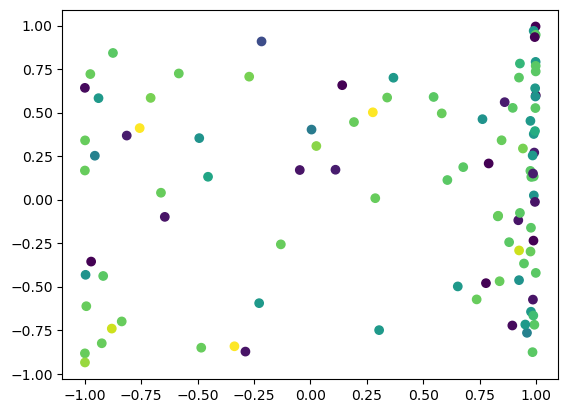

In [10]:
# Plot the generated data
plt.scatter(generated_data[:, 0], generated_data[:, 1], c=np.argmax(generated_data[:, 2:], axis=1))
plt.show()

In [11]:
# Save the discriminator model
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
discriminator.save('../ML/GAN/discriminator.h5')

# Save the generator model
generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
generator.save('../ML/GAN/generator.h5')

# Save the combined model
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
gan.save('../ML/GAN/gan.h5')

In [12]:
# Load the discriminator model
loaded_discriminator = tf.keras.models.load_model('../ML/GAN/discriminator.h5')

# Load the generator model
loaded_generator = tf.keras.models.load_model('../ML/GAN/generator.h5')

# Load the combined model
loaded_gan = tf.keras.models.load_model('../ML/GAN/gan.h5')

In [25]:
# Generate a set of images using random noise vectors
num_images = 1000
noise = np.random.normal(0, 1, size=(num_images, 100))
generated_images = loaded_generator.predict(noise)

# Convert the images to grayscale and flatten them into 1-dimensional arrays
grayscale_images = np.mean(generated_images, axis=1)
flattened_images = grayscale_images.reshape(num_images, -1)

# Save the flattened images as a CSV file
gen_df = pd.DataFrame(flattened_images)
gen_df.to_csv('generated_images.csv', index=False, header=False)


32/32 [==============================] - 0s 14ms/step


3125/3125 [==============================] - 16s 5ms/step


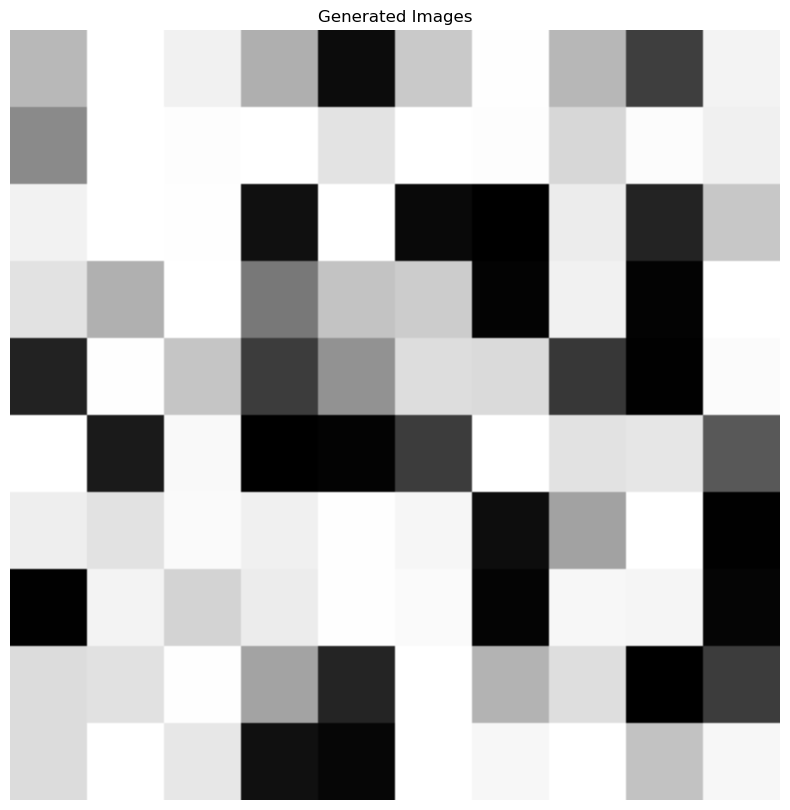

In [29]:
# Generate a set of 100000 images using random noise vectors
num_images = 100000
noise = np.random.normal(0, 1, size=(num_images, 100))
generated_images = loaded_generator.predict(noise)

# Reshape the images into a 10x10 grid
grid_size = 10
grid = np.zeros((grid_size*28, grid_size*28))
for i in range(grid_size):
    for j in range(grid_size):
        img = generated_images[i*grid_size+j, 0]
        grid[i*28:(i+1)*28, j*28:(j+1)*28] = img

# Plot the grid of images
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid, cmap='gray')
ax.axis('off')
ax.set_title('Generated Images')
plt.show()


In [13]:
# Tensorflow Warning Fix
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),))
def next_collatz(x):
    print("Tracing with", x)
    return tf.where(x % 2 == 0, x // 2, 3 * x + 1)

In [14]:
# Custom input data
input_data = np.array([[0,1,24,9,206,1491,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,17,20,0.0,0.0,0.0,0.0,1.0,0.0,0.1,0,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11]])
# input_data = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2]])

# Make a prediction using the model
prediction_data = discriminator.predict(input_data)

print(prediction_data)

1/1 [==============================] - 0s 176ms/step
[[1.]]
